In [1]:
##Import all the necessary libraries
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

The below part has been prepared with taking help from<br>
https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb<br>
One confusion this notebook helped clear was that we have to loop all over the images.<br>
Collect the corners and then calculate Distortion Coeffecients.<br>
I unclear on how to calculate the coffecinets on a number of images.

In [2]:
###Prepare the object points
####Setting the object points to 9 
##as advised in Tips & Tricks for the project
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [4]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [5]:
### Calcualte the distortion coefficenets
### Assuming all images are of the same size
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [6]:
##Write output undistorted images to an output folder
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imsave("camera_cal_output/undist"+fname[11:],dst)

In [7]:
###Write undistorted test image output 
# Make a list of calibration images
images_list1 = glob.glob('test_images/test*.jpg')
images_list2 = glob.glob('test_images/straight_lines*.jpg')

for idx, fname in enumerate(images_list1):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imsave("test_images_undist_output/undist_"+fname[12:],dst)

for idx, fname in enumerate(images_list2):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    plt.imsave("test_images_undist_output/undist_"+fname[12:],dst)

Here we start the next part of the pipeline.<br>
We will start the color transformations and gradients.

In [8]:

###define function to apply color and threshold gradients
def conv_2_gradcol(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    color_rgb=combined_binary
    
    return color_rgb

In [9]:
# Make a list of images for processing
images_list1 = glob.glob('test_images_undist_output/undist_test*.jpg')
images_list2 = glob.glob('test_images_undist_output/undist_straight_lines*.jpg')

for idx, fname in enumerate(images_list1):
    img = cv2.imread(fname)
    img_gradcolor =  conv_2_gradcol(img) 
    plt.imsave("test_images_grad_output/col_grad_"+fname[33:],img_gradcolor)
    

for idx, fname in enumerate(images_list2):
    img = cv2.imread(fname)
    img_gradcolor =  conv_2_gradcol(img) 
    plt.imsave("test_images_grad_output/col_grad_"+fname[33:],img_gradcolor)

Now for the next stage for the perspective transform.<br>
Lets just display an image to get an idea.<br>

(720, 1280, 3)


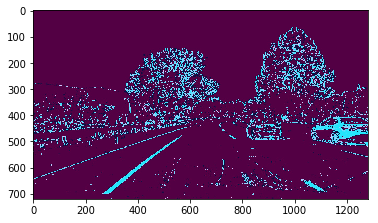

In [10]:
img = cv2.imread('test_images_grad_output/col_grad_test1.jpg')
print(np.shape(img))
plt.imshow(img)

In [11]:
def perspective_transform(img):
    src = np.float32([(180,720),(575,450),(1200,720),(750,450)])
    dest = np.float32([(180,720),(180,0),(1200,720),(1150,0)])
    #lineThickness = 2
    #img_size = (img.shape[1], img.shape[0])
    line_img = img
    #cv2.line(line_img, (180,720), (575,450), (255,0,0), lineThickness)
    #cv2.line(line_img, (180,720), (1200,720), (255,0,0), lineThickness)
    #cv2.line(line_img, (750,450), (1200,720), (255,0,0), lineThickness)
    #cv2.line(line_img, (750,450), (575,450), (255,0,0), lineThickness)
    M = cv2.getPerspectiveTransform(src, dest)
    transformed_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return [line_img,transformed_image]

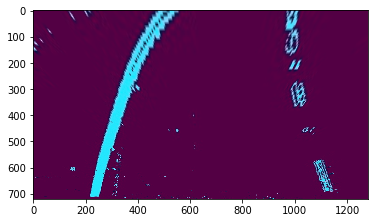

In [12]:
img = cv2.imread('test_images_grad_output/col_grad_test3.jpg')
test_img = perspective_transform(img)
plt.imshow(test_img[1])

In [13]:
# Make a list of images for processing
images_list1 = glob.glob('test_images_grad_output/col_grad_test*.jpg')
images_list2 = glob.glob('test_images_grad_output/col_grad_straight_lines*.jpg')

for idx, fname in enumerate(images_list1):
    img = cv2.imread(fname)
    img_perspective =  perspective_transform(img) 
    plt.imsave("test_images_ROI_output/ROI_"+fname[33:],img_perspective[0])
    plt.imsave("test_image_perspective_output/persp_"+fname[33:],img_perspective[1])
    

for idx, fname in enumerate(images_list2):
    img = cv2.imread(fname)
    img_perspective =  perspective_transform(img) 
    plt.imsave("test_images_ROI_output/ROI_"+fname[33:],img_perspective[0])
    plt.imsave("test_image_perspective_output/persp_"+fname[33:],img_perspective[1])

Lets plot the histogram to get an idea of the starting of the lane images.<br>
Lets try this on the entire image instead of half the image

In [14]:
def hist_inital(img_name,final_piplene_flag= True,img_path_name=''):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    #bottom_half = img[img.shape[0]//2:,:]
    if final_piplene_flag == True:
        binary_warped=img_name
        binary_warped_copy =  cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2RGB)
    else:    
        binary_warped=cv2.imread(img_name) 
        binary_warped_copy = binary_warped.copy()
        binary_warped =  cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    #binary_warped = binary_warped[:,:,0]
    ##We are taking only one channel to avoid unnecessary complications and code failure to fit right lane
    #binary_warped_copy = binary_warped.copy()
    #binary_warped =  cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    (thresh, binary_warped) = cv2.threshold(binary_warped, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #####HARDCODED AT PRESENT WILL CHECK LATER
    #rightx_base=1200
    #leftx_base = 200 
        # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
    
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
       
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
       
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    img_shape=binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #####start the visualization############
    #######################################
    
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped_copy.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    img_shape = binary_warped.shape
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    
    ###############cCHECKPOINT#########################
    
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(binary_warped_copy, 1, window_img, 0.3, 0)
    # Plot the polynomial lines onto the image
    
    ######TEMPORARY COMMENTING AS LINES NOT FETTING WARPED IN INVERSER WARP PERSPECTIVE
    #plt.plot(left_fitx, ploty, color='green')
    #plt.plot(right_fitx, ploty, color='green')
    
    #plt.imshow(result)

    
    ## End visualization steps ##
    
    
    ######Start of part to fill coloer in between the lanes
    #####################################################
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    result = cv2.addWeighted(result, 1, warp_zero, 0.3, 0)
    
    ###########CHECKPOINT#############################
    
    ##########Start Code for overlaying color on original image###########
    #cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #### get imverse perspecitve transform
    src = np.float32([(180,720),(575,450),(1200,720),(750,450)])
    dest = np.float32([(180,720),(180,0),(1200,720),(1150,0)])
    
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    if final_piplene_flag == True:
        test_img = cv2.imread(img_path_name) 
    else:    
        test_img = cv2.imread('test_images/'+img_name[36:])     
    
    newwarp = cv2.warpPerspective(warp_zero, Minv, (test_img.shape[1], test_img.shape[0])) 
    result = cv2.addWeighted(test_img, 1, newwarp, 0.3, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    ################START RADIUS OF CURVATURE######################################
    ###############################################################################
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculation of R_curve (radius of curvature)
    y_eval = result.shape[0]
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #print('Left ROC:- '+str(int(left_curverad)))
    #print('Right ROC:- '+str(int(right_curverad)))
    
    str_ROC = 'Left ROC:- '+str(int(left_curverad))+'m'
    #############DISPLAY TEXT ON IMAGE####################
    ######################################################
    
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,100)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 5

    cv2.putText(result,str_ROC, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    img_midpoint = result.shape[0]*xm_per_pix
    lane_midpoint =(leftx_base*xm_per_pix+rightx_base*xm_per_pix)/2
    
    if lane_midpoint < img_midpoint:
        str_position = 'Vehicle is '+str(round(abs(img_midpoint-lane_midpoint),2))+' m left of centre'
    else:
        str_position = 'Vehicle is '+str(round(abs(img_midpoint-lane_midpoint),2))+' m right of centre'
    
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,200)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 5

    cv2.putText(result,str_position, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    
    return result

In [15]:
def hist_inital_video(img_name,original_image,final_piplene_flag= True,img_path_name=''):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    #bottom_half = img[img.shape[0]//2:,:]
    if final_piplene_flag == True:
        binary_warped=img_name
        binary_warped_copy =  cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2RGB)
    else:    
        binary_warped=cv2.imread(img_name) 
        binary_warped_copy = binary_warped.copy()
        binary_warped =  cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    #binary_warped = binary_warped[:,:,0]
    ##We are taking only one channel to avoid unnecessary complications and code failure to fit right lane
    #binary_warped_copy = binary_warped.copy()
    #binary_warped =  cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    (thresh, binary_warped) = cv2.threshold(binary_warped, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #####HARDCODED AT PRESENT WILL CHECK LATER
    #rightx_base=1200
    #leftx_base = 200 
        # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
    
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
       
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
       
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    img_shape=binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #####start the visualization############
    #######################################
    
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped_copy.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    img_shape = binary_warped.shape
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    
    ###############cCHECKPOINT#########################
    
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    ##cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    ##cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(binary_warped_copy, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    
    ######TEMPORARY COMMENTING AS LINES NOT FETTING WARPED IN INVERSER WARP PERSPECTIVE
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    ## End visualization steps ##
    
    
    ######Start of part to fill coloer in between the lanes
    #####################################################
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    result = cv2.addWeighted(result, 1, warp_zero, 0.3, 0)
    
    ###########CHECKPOINT#############################
    
    ##########Start Code for overlaying color on original image###########
    #cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #### get imverse perspecitve transform
    src = np.float32([(180,720),(575,450),(1200,720),(750,450)])
    dest = np.float32([(180,720),(180,0),(1200,720),(1150,0)])
    
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    if final_piplene_flag == True:
        test_img = original_image 
    else:    
        test_img = original_image     
    
    newwarp = cv2.warpPerspective(warp_zero, Minv, (test_img.shape[1], test_img.shape[0])) 
    result = cv2.addWeighted(test_img, 1, newwarp, 0.3, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    ################START RADIUS OF CURVATURE######################################
    ###############################################################################
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculation of R_curve (radius of curvature)
    y_eval = result.shape[0]
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #print('Left ROC:- '+str(int(left_curverad)))
    #print('Right ROC:- '+str(int(right_curverad)))
    
    str_ROC = 'Left ROC:- '+str(int(left_curverad))+'m'
    #############DISPLAY TEXT ON IMAGE####################
    ######################################################
    
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,100)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 5

    cv2.putText(result,str_ROC, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    img_midpoint = result.shape[0]*xm_per_pix
    lane_midpoint =(leftx_base*xm_per_pix+rightx_base*xm_per_pix)/2
    
    if lane_midpoint < img_midpoint:
        str_position = 'Vehicle is '+str(round(abs(img_midpoint-lane_midpoint),2))+' m left of centre'
    else:
        str_position = 'Vehicle is '+str(round(abs(img_midpoint-lane_midpoint),2))+' m right of centre'
    
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,200)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 5

    cv2.putText(result,str_position, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    
    return result

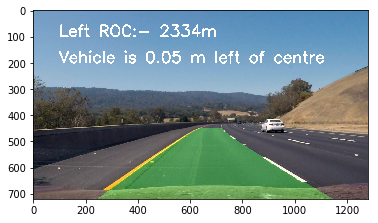

In [16]:
img_name = 'test_image_perspective_output/persp_test3.jpg'
result = hist_inital(img_name,False)
plt.imshow(result)

Need some advice from mentors if such a large difference between left and right curvatures are possible.<br>
Left ROC:- 7312
Right ROC:- 1902

Now Lets combine everything into one function<br>
This will be a complete end to end pipeline where we pass test image name and get an image like the one above<br>
Lets go !!!!!

In [17]:
def complete_image_process_pipeline(img_path_name,ret, mtx, dist, rvecs, tvecs , video_flag = True):
    ##################START OF UNDISTORT IMAGE################################
    ##########################################################################

    if video_flag == True:
        img = img_path_name
    else:
        img = cv2.imread(img_path_name)
    
    
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    #plt.imshow(dst)
	##################################START OF COLOR TRANSFORMATION AND GRADIENTS############
	#########################################################################################
	
    img_gradcolor = conv_2_gradcol(dst)
    #plt.imshow(img_gradcolor)
	########################################START OF PERSPECTIVE TRANSFORM##################
	########################################################################################
	
    persp_transform_img = perspective_transform(img_gradcolor)
    #plt.imshow(persp_transform_img[1])
	
	######################################STSRT OF HISTOGRAM###############################
	#######################################################################################
	
    if video_flag == True:
        final_result = hist_inital_video(persp_transform_img[1],img,True,img_path_name)
    else:
        final_result = hist_inital(persp_transform_img[1],True,img_path_name)
	
    
    return final_result

In [18]:
img_name='test_images/test1.jpg'
final_result=complete_image_process_pipeline(img_name,ret, mtx, dist, rvecs, tvecs,False)
#plt.imshow(final_result)

In [19]:
###Write undistorted test image output 
# Make a list of calibration images
images_list1 = glob.glob('test_images/test*.jpg')
images_list2 = glob.glob('test_images/straight_lines*.jpg')

for idx, fname in enumerate(images_list1):
    img = cv2.imread(fname)
    final_result=complete_image_process_pipeline(fname,ret, mtx, dist, rvecs, tvecs, False)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    plt.imsave("test_images_final_output/final_output_"+fname[12:],final_result)

for idx, fname in enumerate(images_list2):
    iimg = cv2.imread(fname)
    final_result=complete_image_process_pipeline(fname,ret, mtx, dist, rvecs, tvecs, False)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    plt.imsave("test_images_final_output/final_output_"+fname[12:],final_result)

The images in test_images_final_output are lloking good..<br>
Now for the final summit push....<br>
The video.<br>


In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = complete_image_process_pipeline(image,ret, mtx, dist, rvecs, tvecs)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    #plt.imsave("video_image/image.jpg",result)
    return result

In [22]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:04<00:00,  4.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 5s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))